In [1]:
import torch
import torchvision.transforms as transforms

import os
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image, ImageDraw

# Data

## Encoder

In [2]:
def meshgrid(x, y, row_major=True):
    a = torch.arange(0, x)
    b = torch.arange(0, y)
    xx = a.repeat(y).view(-1, 1)
    yy = b.view(-1, 1).repeat(1, x).view(-1, 1)
    return torch.cat([xx, yy], 1) if row_major else torch.cat([yy, xx], 1)

def change_box_order(boxes, order):
    assert order in ['xyxy2xywh', 'xywh2xyxy']
    a = boxes[:, :2]
    b = boxes[:, 2:]
    if order == 'xyxy2xywh':
        return torch.cat([(a + b) / 2, b - a + 1], 1)
    return torch.cat([a - b / 2, a + b / 2], 1)

def box_iou(box1, box2, order='xyxy'):
    if order == 'xywh':
        box1 = change_box_order(box1, 'xywh2xyxy')
        box2 = change_box_order(box2, 'xywh2xyxy')

    N = box1.size(0)
    M = box2.size(0)

    lt = torch.max(box1[:, None, :2], box2[:, :2])
    rb = torch.min(box1[:, None, 2:], box2[:, 2:])

    wh = (rb - lt + 1).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    area1 = (box1[:, 2] - box1[:, 0] + 1) * (box1[:, 3] - box1[:, 1] + 1)
    area2 = (box2[:, 2] - box2[:, 0] + 1) * (box2[:, 3] - box2[:, 1] + 1)
    iou = inter / (area1[:, None] + area2 - inter)

    # print(area1)
    # print(area1.shape)
    # print(area2)
    # print(area2.shape)
    # print(f"iou: {iou}")
    return iou

def box_nms(bboxes, scores, threshold=0.5, mode='union'):
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    _, order = scores.sort(0, descending=True)
    keep = []
    sco = []

    while order.numel() > 0:
        i = order[0] if order.numel() > 1 else order.item()
        keep.append(i)
        sco.append(scores[i])

        if order.numel() == 1:
            break

        xx1 = x1[order[1:]].clamp(min=x1[i])
        yy1 = y1[order[1:]].clamp(min=y1[i])
        xx2 = x2[order[1:]].clamp(max=x2[i])
        yy2 = y2[order[1:]].clamp(max=y2[i])

        w = (xx2 - xx1 + 1).clamp(min=0)
        h = (yy2 - yy1 + 1).clamp(min=0)
        inter = w * h

        if mode == 'union':
            ovr = inter / (areas[i] + areas[order[1:]] - inter)
        elif mode == 'min':
            ovr = inter / areas[order[1:]].clamp(max=areas[i])
        else:
            raise TypeError(f"Unknow nms mode: {mode}.")

        ids = (ovr <= threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids + 1]
    return torch.LongTensor(keep), torch.Tensor(sco)

In [37]:
class DataEncoder:
    def __init__(self, input_scales):
        self.input_area = input_scales[0] * input_scales[1]
        self.anchor_areas = [32*32, 64*64, 128*128, 256*256, 512*512] # p3 -> p7
        self.aspect_ratios = (0.5, 1.0, 2.0)
        self.scale_ratios = (1.0, pow(2.0, 1.0/3.0), pow(2.0, 2.0/3.0))
        self.anchor_wh = self._get_anchor_wh()

    def _get_anchor_wh(self):
        anchor_wh = []
        for s in self.anchor_areas:
            for ar in self.aspect_ratios:
                h = math.sqrt(s / ar)
                w = ar * h
                for sr in self.scale_ratios:
                    anchor_h = h * sr
                    anchor_w = w * sr
                    anchor_wh.append([anchor_w, anchor_h])
        num_fms = len(self.anchor_areas)
        return torch.Tensor(anchor_wh).view(num_fms, -1, 2)

    def _get_anchor_boxes(self, input_size):
        num_fms = len(self.anchor_areas)
        fm_sizes = [(input_size / pow(2., i+3)).ceil() for i in range(num_fms)]

        boxes = []
        for i in range(num_fms):
            fm_size = fm_sizes[i]
            grid_size = input_size / fm_size
            fm_w, fm_h = int(fm_size[0]), int(fm_size[1])
            xy = meshgrid(fm_w, fm_h) + 0.5
            xy = (xy * grid_size).view(fm_h, fm_w, 1, 2).expand(fm_h, fm_w, 9, 2)
            wh = self.anchor_wh[i].view(1, 1, 9, 2).expand(fm_h, fm_w, 9, 2)
            box = torch.cat([xy, wh], 3)
            boxes.append(box.view(-1, 4))
        return torch.cat(boxes, 0)

    def encode(self, boxes, labels, input_size):
        input_size = torch.Tensor([input_size, input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size)
        boxes = change_box_order(boxes, 'xyxy2xywh')

        ious = box_iou(anchor_boxes, boxes, 'xywh')
        max_ious, max_ids = ious.max(1)
        boxes = boxes[max_ids]

        loc_xy = (boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:]
        loc_wh = torch.log(boxes[:, 2:] / anchor_boxes[:, 2:])
        loc_targets = torch.cat([loc_xy, loc_wh], 1)
        cls_targets = 1 + labels[max_ids]

        cls_targets[max_ious < 0.5] = 0
        ignore = (max_ious > 0.4) & (max_ious < 0.5)
        cls_targets[ignore] = -1
        return loc_targets, cls_targets

    def decode(self, loc_preds, cls_preds, input_size):
        CLS_THRESH = 0.35
        NMS_THRESH = 0.6

        input_size = torch.Tensor([input_size, input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size)

        loc_xy = loc_preds[:, :2]
        loc_wh = loc_preds[:, 2:]

        xy = loc_xy * anchor_boxes[:, 2:] + anchor_boxes[:, :2]
        wh = loc_wh.exp() * anchor_boxes[:, 2:]
        boxes = torch.cat([xy - wh / 2, xy + wh / 2], 1)

        score, labels = cls_preds.sigmoid().max(1)
        ids = score > CLS_THRESH
        ids = ids.nonzero().squeeze()
        if not ids.size():
            return torch.tensor([0, 0, 0, 0]), torch.tensor([0]), torch.tensor([0]), False
        if ids.size()[0] == 0:
            return torch.tensor([0, 0, 0, 0]), torch.tensor([0]), torch.tensor([0]), False
        keep, sco = box_nms(boxes[ids], score[ids], threshold=NMS_THRESH)
        return boxes[ids][keep], labels[ids][keep], sco, True

## Shrimp dataset class

In [38]:
def resize(img, boxes, size, max_size=1000):
    ## **warning
    w, h = img.size
    if isinstance(size, int):
        size_min = min(w, h)
        size_max = max(w, h)
        # print(f"size min : {size_min}")
        # print(f"size max : {size_max}")
        sw = sh = float(size) / size_min
        if sw * size_max > max_size:
            sw = sh = float(max_size) / size_max
        ow = int(w * sw + 0.5)
        oh = int(h * sh + 0.5)
    else:
        ow, oh = size
        sw = float(ow) / w
        sh = float(oh) / h
    return img.resize((ow, oh), Image.BILINEAR), boxes * torch.Tensor([sw, sh, sw, sh])

def random_crop(img, boxes):
    success = False
    for attempt in range(10):
        area = img.size[0] * img.size[1]
        target_area = random.uniform(0.56, 1.0) * area
        aspect_ratio = random.uniform(3. / 4, 4. / 3)

        w = int(round(math.sqrt(target_area * aspect_ratio)))
        h = int(round(math.sqrt(target_area / aspect_ratio)))

        if random.random() < 0.5:
            w, h = h, w
        
        if w <= img.size[0] and h <= img.size[1]:
            x = random.randint(0, img.size[0] - w)
            y = random.randint(0, img.size[1] - h)
            success = True
            break

    # Fallback
    if not success:
        w = h = min(img.size[0], img.size[1])
        x = (img.size[0] - w) // 2
        y = (img.size[1] - h) // 2

    img = img.crop((x, y, x + w, y + h))
    boxes -= torch.Tensor([x, y, x, y])
    boxes[:, 0::2].clamp_(min=0, max=w-1)
    boxes[:, 1::2].clamp_(min=0, max=h-1)
    return img, boxes

def center_crop(img, boxes, size):
    w, h = img.size
    ow, oh = size
    i = int(round((h - oh) / 2.))
    j = int(round((w - ow) / 2.))
    img = img.crop((j, i, j + ow, i + oh))
    boxes -= torch.Tensor([j, i, j, i])
    boxes[:, 0::2].clamp_(min=0, max=ow-1)
    boxes[:, 1::2].clamp_(min=0, max=oh-1)
    return img, boxes

def random_flip(img, boxes):
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        w = img.width
        xmin = w - boxes[:, 2]
        xmax = w - boxes[:, 0]
        boxes[:, 0] = xmin
        boxes[:, 2] = xmax
    return img, boxes

In [39]:
class ShrimpDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, image_scales, get_segmentation=False):
        self.category = ['shrimp']
        self.img_root_dir = os.path.join(dataset_dir, 'imgs')
        self.img_list = os.path.join(dataset_dir, 'image_list.txt')
        self.annotations_dir = os.path.join(dataset_dir, 'annotations')
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])
        self.train = True
        self.input_size = image_scales

        self.fnames = []
        self.boxes = []
        self.labels = []
        self.num_samples = 0
        self.get_img_annotations()
        self.get_segmentation = get_segmentation

        self.encoder = DataEncoder(self.input_size)

    def get_img_annotations(self):
        with open(self.img_list) as f:
            lines = f.readlines()
        self.num_samples = len(lines)

        for line in lines:
            splited = line.strip()
            self.fnames.append(splited + '.jpg')
            box = []
            label = []
            ann = os.path.join(self.annotations_dir, splited + '.xml')
            rec = parse_rec(ann)
            for r in rec:
                box.append(r['bbox'])
                label.append(self.category.index(r['name']))
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))
        
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = Image.open(os.path.join(self.img_root_dir, fname))

        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Denoise image
        img = self.denoise(img)

        boxes = self.boxes[idx].clone()
        labels = self.labels[idx]
        size = self.input_size

        # data augmentation
        if self.train:
            img, boxes = resize(img, boxes, size)
        else:
            img, boxes = resize(img, boxes, size)
            img, boxes = center_crop(img, boxes, size) ##**

        if self.get_segmentation:
            img = self.segmentation(img)

        # Normalize
        img = self.transform(img)
        return img, boxes, labels

    def __len__(self):
        return self.num_samples

    def denoise(self, img):
        # convert PIL image to cv2 image
        img = np.array(img)

        # denoise
        img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

        # convert cv2 image to PIL image
        img = Image.fromarray(img)
        return img

    def segmentation(self, img):
        # convert PIL image to cv2 image
        img = np.array(img)

        # init input for kmean
        twoDimage = img.reshape((-1, 3))
        twoDimage = np.float32(twoDimage)

        # init parameter for kmean
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        k = 2
        attempts = 10

        # kmean
        ret, label, center = cv2.kmeans(twoDimage, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        result_image = res.reshape((img.shape))
        
        # convert cv2 image to PIL image
        result_image = Image.fromarray(result_image)

        return result_image

    def collate_fn(self, batch):
        imgs = [x[0] for x in batch]
        boxes = [x[1] for x in batch]
        labels = [x[2] for x in batch]

        h = self.input_size[1]
        w = self.input_size[0]
        num_imgs = len(imgs)
        inputs = torch.zeros(num_imgs, 3, h, w)

        loc_targets = []
        cls_targets = []
        for i in range(num_imgs):
            inputs[i] = imgs[i]
            loc_target, cls_target = self.encoder.encode(boxes[i], labels[i], input_size=(w, h))
            loc_targets.append(loc_target)
            cls_targets.append(cls_target)
        return inputs, torch.stack(loc_targets), torch.stack(cls_targets)

def parse_rec(filename):
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        obj_struct['truncated'] = int(obj.find('truncated').text)
        obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text),
                            int(bbox.find('ymin').text),
                            int(bbox.find('xmax').text),
                            int(bbox.find('ymax').text)]
        objects.append(obj_struct)

    return objects

In [40]:
def load_data(dataset_detail):
    dataset = ShrimpDataset(dataset_detail[0], dataset_detail[1], False)
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=dataset_detail[2], shuffle=True, collate_fn=dataset.collate_fn)

    return dataset_loader

# Define model

## Loss

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

In [42]:
def one_hot_embedding(labels, num_classes):
    y = torch.eye(num_classes)
    return y[labels]

In [43]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes=1):
        super(FocalLoss, self).__init__()
        self.num_classes = num_classes

    def focal_loss(self, x, y):
        alpha = 0.25
        gamma = 2.0

        t = one_hot_embedding(y.data.cpu(), 1 + self.num_classes)
        t = t[:, 1:]
        t = Variable(t).cuda()

        p = x.sigmoid()
        pt = p * t + (1 - p) * (1 - t)
        w = alpha * t + (1 - alpha) * (1 - t)
        w = w * (1 - pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)

    def focal_loss_alt(self, x, y):
        # define gamma = 2
        alpha = 0.25
        
        t = one_hot_embedding(y.data.cpu(), 1 + self.num_classes)
        t = t[:, 1:]
        t = Variable(t).cuda()

        xt = x * (2 * t -1)
        pt = (2 * xt + 1).sigmoid()

        w = alpha * t + (1 - alpha) * (1 - t)
        loss = -w * pt.log() / 2
        return loss.sum()

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        batch_size, num_boxes = cls_targets.size()
        pos = cls_targets > 0
        num_pos = pos.data.long().sum()
        num_pos = num_pos.type(torch.cuda.FloatTensor)

        ################################################################
        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        ################################################################
        mask = pos.unsqueeze(2).expand_as(loc_preds)
        masked_loc_preds = loc_preds[mask].view(-1, 4)
        masked_loc_targets = loc_targets[mask].view(-1, 4)
        loc_loss = F.smooth_l1_loss(masked_loc_preds, masked_loc_targets, size_average=False)

        ################################################################
        # cls_loss = FocalLoss(loc_preds, loc_targets)
        ################################################################
        pos_neg = cls_targets > -1
        mask = pos_neg.unsqueeze(2).expand_as(cls_preds)
        masked_cls_preds = cls_preds[mask].view(-1, self.num_classes)
        cls_loss = self.focal_loss_alt(masked_cls_preds, cls_targets[pos_neg])

        return loc_loss/num_pos, cls_loss/num_pos

## RetinaNet

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### FPN

In [11]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.downsample = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += self.downsample(x)
        out = F.relu(out)
        
        return out

In [12]:
class FPN(nn.Module):
    def __init__(self, block, num_blocks):
        super(FPN, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Bottom-up layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.conv6 = nn.Conv2d(2048, 256, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)

        # Top-down layers
        self.toplayer1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.toplayer2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        _, _, H, W = y.size()
        return F.upsample(x, size=(H, W), mode='bilinear', align_corners=True) + y

    def forward(self, x):
        # Bottom-up
        c1 = F.relu(self.bn1(self.conv1(x)))
        c1 = F.max_pool2d(c1, kernel_size=3, stride=2, padding=1)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        p6 = self.conv6(c5)
        p7 = self.conv7(F.relu(p6))

        # Top_down
        p5 = self.latlayer1(c5)
        p4 = self._upsample_add(p5, self.latlayer2(c4))
        p4 = self.toplayer1(p4)
        p3 = self._upsample_add(p4, self.latlayer3(c3))
        p3 = self.toplayer2(p3)
        return p3, p4, p5, p6, p7

def FPN50():
    return FPN(Bottleneck, [3, 4, 6, 3])

def FPN101():
    return FPN(Bottleneck, [2, 4, 23, 3])

### RetinaNet model

In [13]:
OPTIMIZER = 'sgd'
OPTIM_BASE_LR = 0.001
OPTIM_MOMENTUM = 0.9
OPTIM_ALPHA = 0.5
OPTIM_EPS = 1e-8
OPTIM_WEIGHT_DECAY = 0.0005
OPTIM_BETA = (0.9, 0.999)

In [14]:
class RetinaNet(nn.Module):
    num_anchors = 9
    
    def __init__(self, nets='FPN50', num_classes=1):
        super(RetinaNet, self).__init__()
        self.fpn = nets()
        self.num_classes = num_classes
        self.loc_head = self._make_head(self.num_anchors * 4)
        self.cls_head = self._make_head(self.num_anchors * self.num_classes)

    def forward(self, x):
        fms = self.fpn(x)
        loc_preds = []
        cls_preds = []
        for fm in fms:
            loc_pred = self.loc_head(fm)
            cls_pred = self.cls_head(fm)
            loc_pred = loc_pred.permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 4)
            cls_pred = cls_pred.permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.num_classes)
            loc_preds.append(loc_pred)
            cls_preds.append(cls_pred)

        return torch.cat(loc_preds, 1), torch.cat(cls_preds, 1)

    def _make_head(self, out_planes):
        layers = []
        for _ in range(4):
            layers.append(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.Conv2d(256, out_planes, kernel_size=3, stride=1, padding=1))
        return nn.Sequential(*layers)

    def freeze_bn(self):
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

In [15]:
def create(conv_body, num_classes):
    networks_map = {
        'ResNet50_FPN': FPN50,
        'ResNet101_FPN': FPN101
    }

    model = RetinaNet(networks_map[conv_body], num_classes)
    return model

def config_optimizer(param):
    print(f"using {OPTIMIZER}: base_learning_rate = {OPTIM_BASE_LR}, momentum = {OPTIM_MOMENTUM}, weight_decay = {OPTIM_WEIGHT_DECAY}")
    if OPTIMIZER == 'sgd':
        optimizer = optim.SGD(param, lr=OPTIM_BASE_LR, momentum=OPTIM_MOMENTUM, weight_decay=OPTIM_WEIGHT_DECAY)
    elif OPTIMIZER == 'rmsprop':
        optimizer = optim.RMSprop(param, lr=OPTIM_BASE_LR, momentum=OPTIM_MOMENTUM, alpha=OPTIM_ALPHA, eps=OPTIM_EPS, weight_decay=OPTIM_WEIGHT_DECAY)
    elif OPTIMIZER == 'adam':
        optimizer = optim.Adam(param, lr=OPTIM_BASE_LR, betas=OPTIM_BETA, eps=OPTIM_EPS, weight_decay=OPTIM_WEIGHT_DECAY)
    else:
        AssertionError('optimizer can not be recognized.')
    return optimizer

# Train

In [16]:
import os
import numpy as np
import torch.nn.init as init

In [17]:
MODEL_CONV_BODY = 'ResNet50_FPN'
MODEL_NUM_CLASSES = 1
MODEL_CHECKPOINT_DIR = 'D:/ForME/3_Data/shrimp/checkpoint'

TRAIN_AUTO_RESUME = False
TRAIN_RESUME_FILE = ''
TRAIN_DATASET = ('D:/ForME/3_Data/shrimp/train', (600, 600), 1) # dir_path, image_size(800, ), batch_size(8)
TRAIN_MAX_ITER = 100

VALID_DATASET = ('D:/ForME/3_Data/shrimp/val', (600, 600), 1)

In [18]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint', loss=None):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = loss
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
    
    def __call__(self, val_loss, model, epoch):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...") 
        state = {
            'net': model.state_dict(),
            'loss': self.best_score,
            'epoch': epoch
        }
        torch.save(state, os.path.join(self.path, f"fpn50_b1_600_{epoch}_{val_loss:.3f}.pkl"))
        self.val_loss_min = val_loss

In [19]:
def create_train_model():
    start_iter = 0
    min_loss = None
    if os.path.exists(os.path.join(MODEL_CHECKPOINT_DIR, f"FPN50.pkl")):
        if TRAIN_AUTO_RESUME:
            checkpoints = torch.load(os.path.join(MODEL_CHECKPOINT_DIR, TRAIN_RESUME_FILE))
            start_iter = checkpoints['epoch']
            if start_iter > 0:
                weights = checkpoints['net']
                min_loss = checkpoints['loss']
    else:
        weights = None
    model = create(MODEL_CONV_BODY, MODEL_NUM_CLASSES)
    return model, weights, start_iter, min_loss

def init_weight(model):
    for name, param in model.named_parameters():
        try:
            if 'bias' in name:
                init.constant_(param, 0.0)
            elif 'weight' in name:
                init.normal_(param)
        except Exception as e:  # for batchnorm.
            print(name)
            if 'weight' in name:
                param.data.fill_(1)
            continue

def setup_train_model(model, weights, train=False):
    if weights is not None:
        model.load_state_dict(weights)
    else:
        # init_weight(model)
        print('weight init')
    if not torch.cuda.is_available():
        raise print(f"You could use GPU for train model")
    model.cuda()

In [20]:
def train_model():
    model, weight, start_iter, min_loss = create_train_model()
    setup_train_model(model, weight, train=True)

    trainloader = load_data(TRAIN_DATASET)
    validloader = load_data(VALID_DATASET)
    optimizer = config_optimizer(param=model.parameters())
    criterion = FocalLoss(num_classes=MODEL_NUM_CLASSES)

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []

    early_stopping = EarlyStopping(patience=10, verbose=True, path=MODEL_CHECKPOINT_DIR, loss=min_loss)

    for cur_iter in range(start_iter, TRAIN_MAX_ITER):
        print(f"Epoch: {cur_iter}")

        ###################
        # train the model #
        ###################
        model.train()
        model.freeze_bn()
        for batch_idx, (inputs, loc_targets, cls_targets) in enumerate(trainloader):
            inputs = torch.autograd.Variable(inputs.cuda())
            loc_targets = torch.autograd.Variable(loc_targets.cuda())
            cls_targets = torch.autograd.Variable(cls_targets.cuda())

            # print(loc_targets.shape)
            optimizer.zero_grad()
            loc_preds, cls_preds = model(inputs)
            # print(loc_preds.shape)
            loc_loss, cls_loss = criterion(loc_preds, loc_targets, cls_preds, cls_targets)
            loss = loc_loss + cls_loss
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
            # show status
            if batch_idx % 1 == 0:
                print(f"batch idx: {batch_idx} => loc_loss: {loc_loss.item()} || cls_loss: {cls_loss.item()}  || train_loss: {loss.item()}")
        
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for input, loc_target, cls_target in validloader:
            input = torch.autograd.Variable(input.cuda())
            loc_target = torch.autograd.Variable(loc_target.cuda())
            cls_target = torch.autograd.Variable(cls_target.cuda())

            loc_preds, cls_preds = model(input)
            loc_loss, cls_loss = criterion(loc_preds, loc_target, cls_preds, cls_target)
            loss = loc_loss + cls_loss
            valid_losses.append(loss.item())
        
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f"[epoch: {cur_iter} / {TRAIN_MAX_ITER} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f}]")

        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, model, cur_iter)

        if early_stopping.early_stop:
            print('Early stopping')
            break
    
    return  model, avg_train_losses, avg_valid_losses

In [21]:
model, train_loss, valid_loss = train_model()

weight init
using sgd: base_learning_rate = 0.001, momentum = 0.9, weight_decay = 0.0005
Epoch: 0


D:\anaconda3\envs\shrimp-project\lib\site-packages\torch\nn\functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
D:\anaconda3\envs\shrimp-project\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


batch idx: 0 => loc_loss: 0.11011742800474167 || cls_loss: 79.5125732421875  || train_loss: 79.62268829345703
batch idx: 1 => loc_loss: 0.08428416401147842 || cls_loss: 83.40156555175781  || train_loss: 83.48584747314453
batch idx: 2 => loc_loss: 0.09374912828207016 || cls_loss: 38.69731521606445  || train_loss: 38.79106521606445
batch idx: 3 => loc_loss: 0.09636851400136948 || cls_loss: 75.5224380493164  || train_loss: 75.61880493164062
batch idx: 4 => loc_loss: 0.1192978173494339 || cls_loss: 98.1318359375  || train_loss: 98.25113677978516
batch idx: 5 => loc_loss: 0.09470373392105103 || cls_loss: 48.0244140625  || train_loss: 48.119117736816406
batch idx: 6 => loc_loss: 0.0968405231833458 || cls_loss: 35.404964447021484  || train_loss: 35.50180435180664
batch idx: 7 => loc_loss: 0.0892464742064476 || cls_loss: 28.75559425354004  || train_loss: 28.84484100341797
batch idx: 8 => loc_loss: 0.08826372772455215 || cls_loss: 7.291178226470947  || train_loss: 7.379441738128662
batch idx: 9

In [46]:
import matplotlib.pyplot as plt

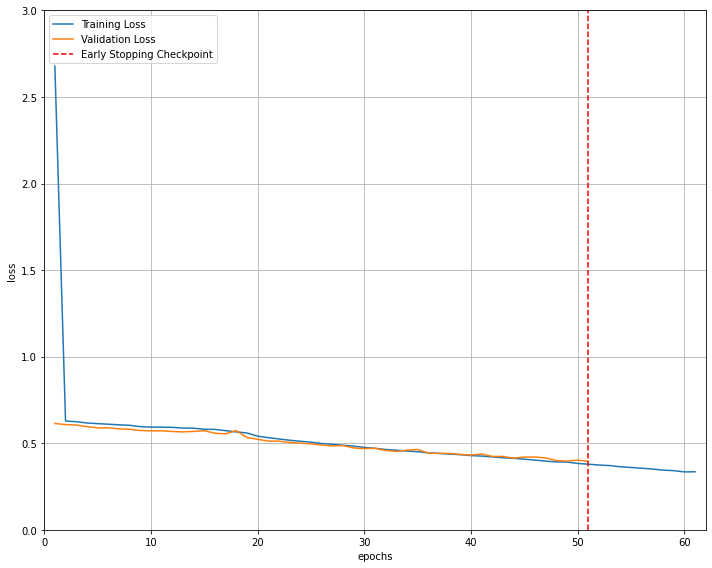

In [48]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 3) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Test

In [22]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [27]:
TEST_DATASET = 'D:/ForME/3_Data/shrimp/test'
VAL_DATASET = 'D:/ForME/3_Data/shrimp/val'
TEST_SCALE = (600, 600)

category = ['shrimp_1', 'shrimp_2']

In [28]:
def denoise(img):
    # convert PIL image to cv2 image
    img = np.array(img)

    # denoise
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    # convert cv2 image to PIL image
    img = Image.fromarray(img)
    return img

def segmentation(img):
    # convert PIL image to cv2 image
    img = np.array(img)

    # init input for kmean
    twoDimage = img.reshape((-1, 3))
    twoDimage = np.float32(twoDimage)

    # init parameter for kmean
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 2
    attempts = 10

    # kmean
    ret, label, center = cv2.kmeans(twoDimage, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    
    # convert cv2 image to PIL image
    result_image = Image.fromarray(result_image)

    return result_image

def preprocess_block(img, test_scales, get_segmentation):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])

    img = denoise(img)
    img = img.resize(test_scales)
    if get_segmentation:
        img = segmentation(img)
    
    plt.imshow(img)
    plt.show()

    img = transform(img)
    return img

In [31]:
def test_model(display=True):
    model = create(MODEL_CONV_BODY, MODEL_NUM_CLASSES)
    try:
        checkpoint = torch.load(os.path.join(MODEL_CHECKPOINT_DIR,'fpn50_b1_600_50_0.395.pkl'))
        model.load_state_dict(checkpoint['net'])
        print('init complete')
    except:
        print(f"not checkpoint")

    if not torch.cuda.is_available():
        raise print(f"You could use GPU for train model")

    model.cuda()
    model.eval()

    img_dir = os.path.join(TEST_DATASET, 'imgs')
    img_list = os.path.join(TEST_DATASET, 'image_list.txt')

    with open(img_list, 'r') as lst : 
        img_list = lst.readlines()
    img_nums = len(img_list)
    print(img_nums)

    test_scales = TEST_SCALE
    dic = {}
    for i in range(1):
        dic[str(i)] = []

    for im in range(img_nums):
        if im % 10 == 0:
            print(f"{im} imgs were processed, total {img_nums}")

        img = Image.open(os.path.join(img_dir, img_list[im].strip() + '.jpg')).convert('RGB')

        img_size = img.size
        
        x = preprocess_block(img, test_scales, True)

        x = x.cuda()
        x = x.unsqueeze(0) # ** why use unsqueeze
        x = torch.autograd.Variable(x)
        loc_preds, cls_preds = model(x)
        print(cls_preds.shape)

        loc_preds = loc_preds.data.squeeze().type(torch.FloatTensor)
        cls_preds = cls_preds.data.squeeze(0).type(torch.FloatTensor)

        print(f"decode: {cls_preds.shape}")

        encoder = DataEncoder(test_scales)
        boxes, labels, sco, is_found = encoder.decode(loc_preds, cls_preds, test_scales)
        print(is_found)
        if is_found:
            img, boxes = resize(img, boxes, img_size)
            img_c = img.copy()
            img_c = np.array(img_c)

            boxes = boxes.ceil()
            xmin = boxes[:, 0].clamp(min=1)
            ymin = boxes[:, 1].clamp(min=1)
            xmax = boxes[:, 2].clamp(max=img_size[0] - 1)
            ymax = boxes[:, 3].clamp(max=img_size[1] - 1)

            nums = len(boxes)
            for i in range(nums):
                dic[str(labels[i].item())].append([img_list[im].strip(), sco[i].item(), xmin[i].item(), ymin[i].item(), xmax[i].item(), ymax[i].item()])

            if display:
                for i in range(nums):
                    cv2.rectangle(img_c, (int(xmin[i]), int(ymin[i])), (int(xmax[i]), int(ymax[i])), (255, 0, 0), 2)
                
                plt.figure(figsize=(10, 8))
                plt.imshow(img_c)
                plt.show()

init complete
100
0 imgs were processed, total 100


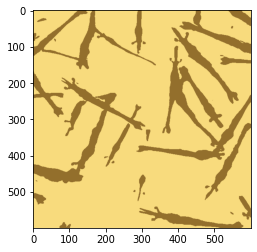

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


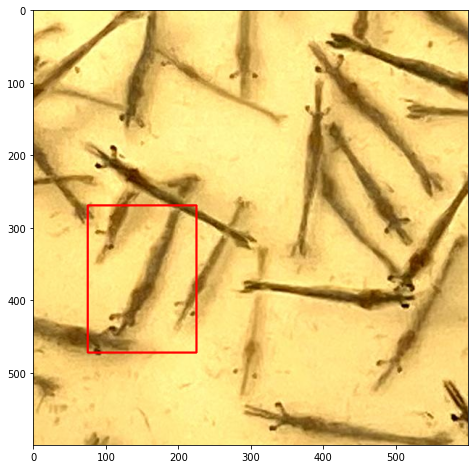

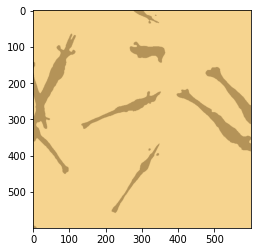

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
False


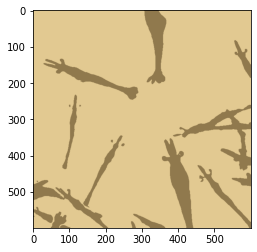

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
False


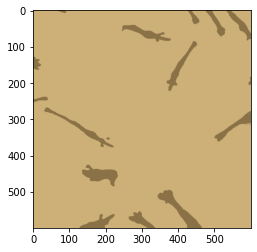

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
False


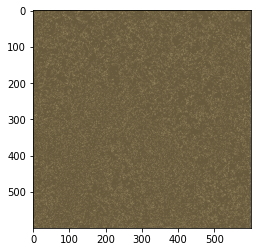

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
False


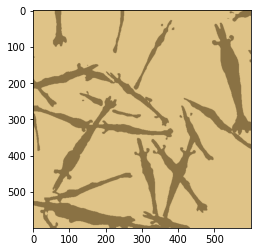

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


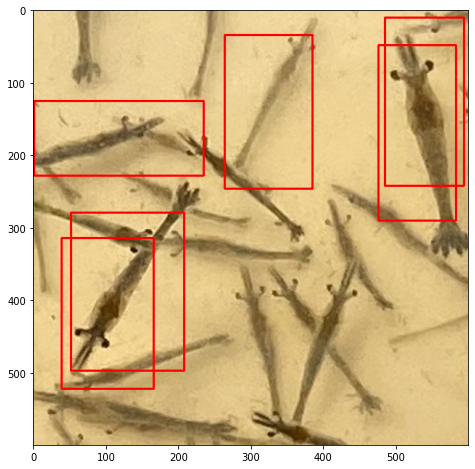

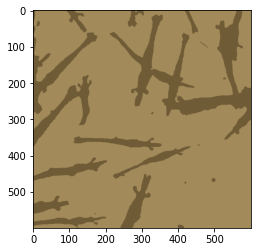

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


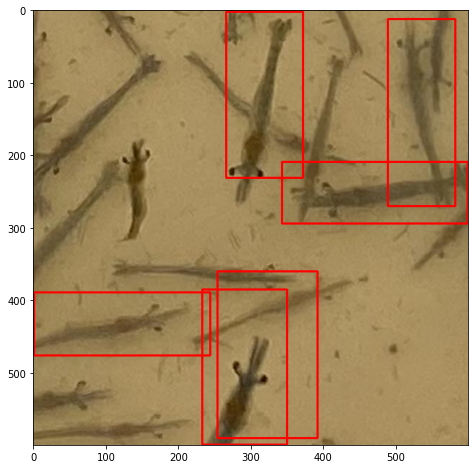

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
False


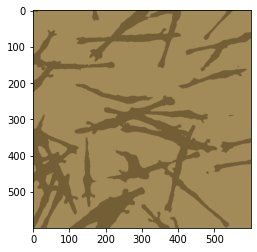

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


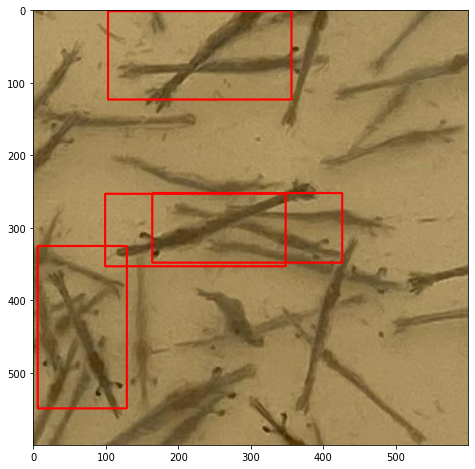

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
False
10 imgs were processed, total 100


torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


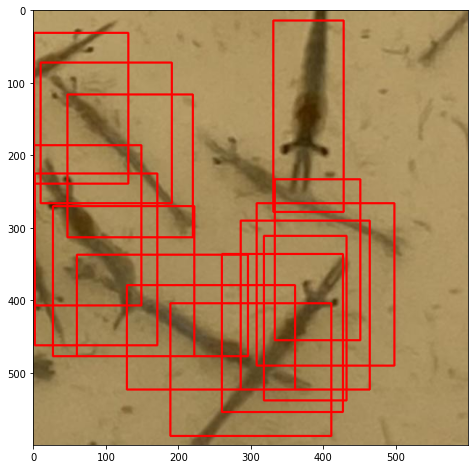

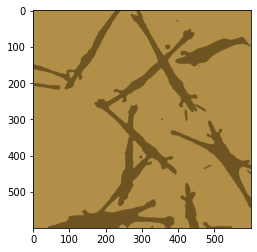

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


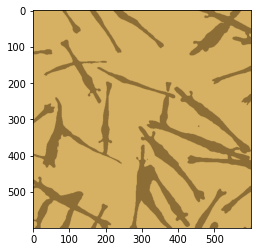

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


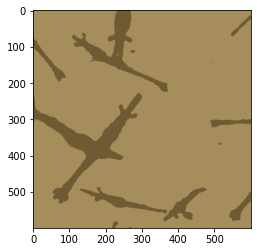

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


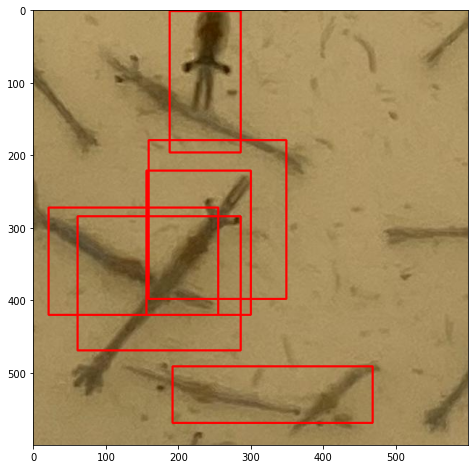

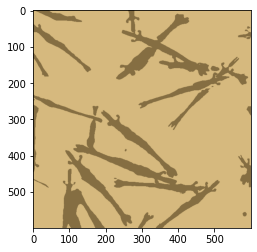

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


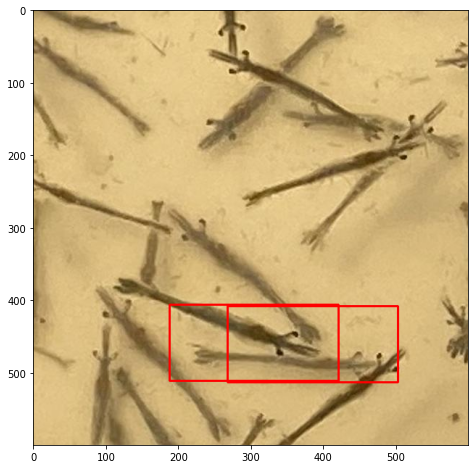

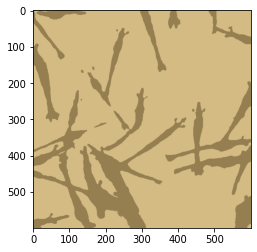

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
False


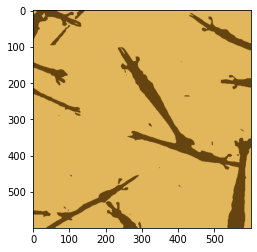

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


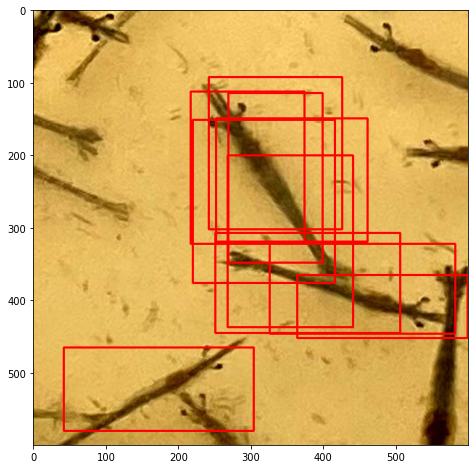

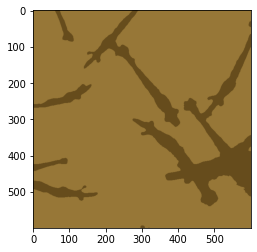

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


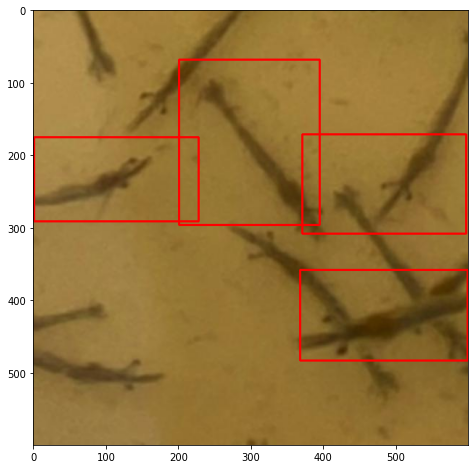

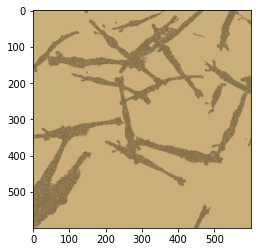

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
False


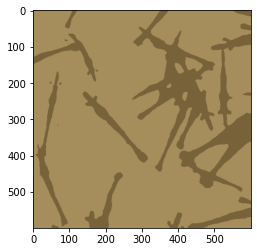

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


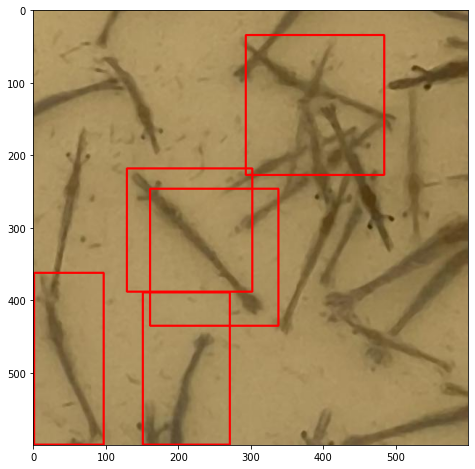

20 imgs were processed, total 100


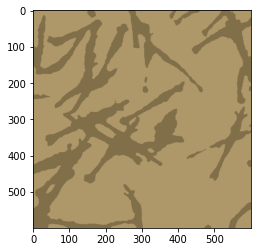

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
False


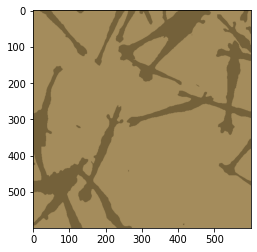

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


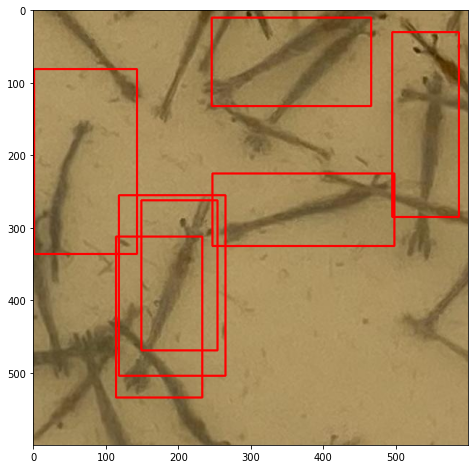

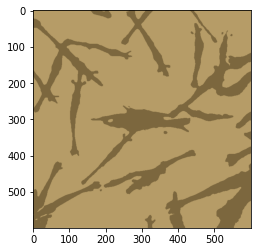

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


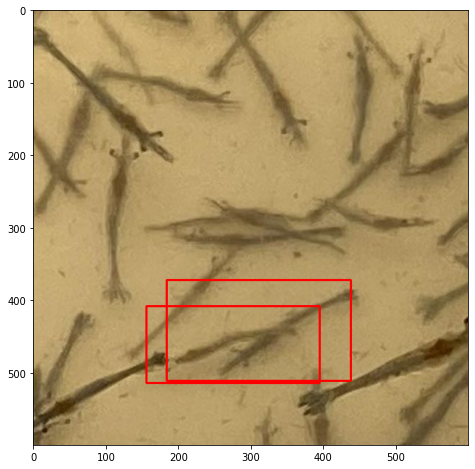

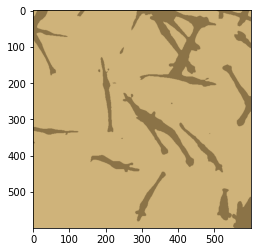

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
False


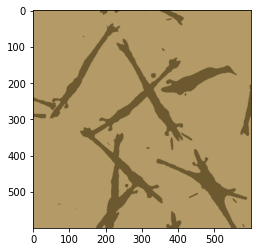

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


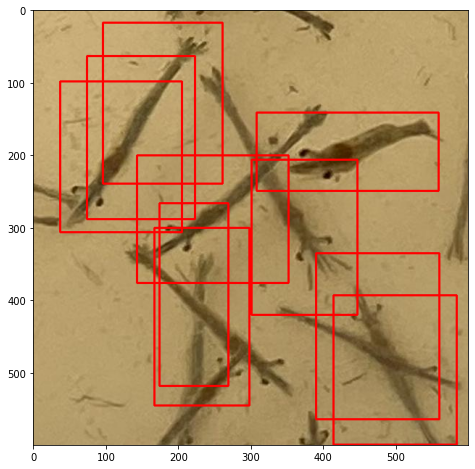

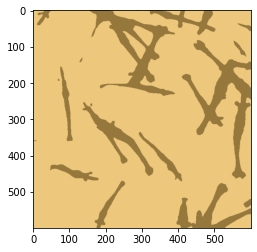

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


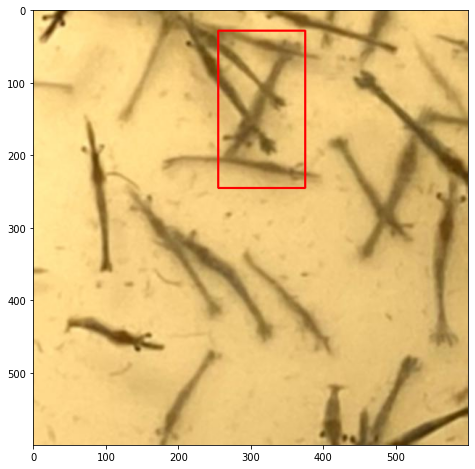

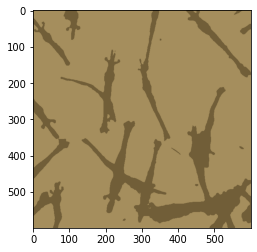

torch.Size([1, 67995, 1])
decode: torch.Size([67995, 1])
True


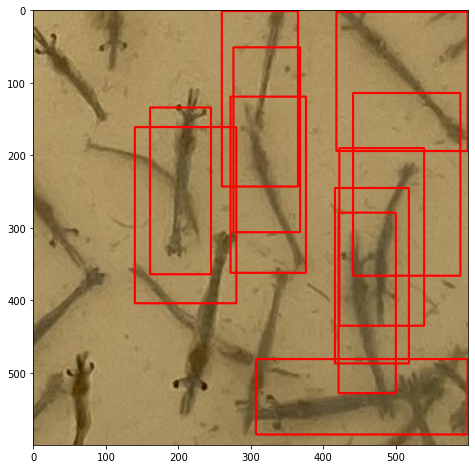

KeyboardInterrupt: 

In [45]:
test_model()